In [1]:
%run custom_datasets.ipynb

Imported classes.


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

## Network initialization

In [3]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        


def set_device():
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('----------------------------------')
    print('Using device for training:', DEVICE)
    print('----------------------------------')
    
    return DEVICE 

def mem(step):
    div = 1024*1024*1024
    
    t = torch.cuda.get_device_properties(0).total_memory
    c = torch.cuda.memory_cached(0)
    a = torch.cuda.memory_allocated(0)

    print(step)
    print("Memory cached:", round(c/div, 3))
    print("Memory allocated:", round(c/div, 3))
    print()

In [4]:
data = PrepareData3D(["Aorta Volunteers", "Aorta BaV", "Aorta Resvcue", "Aorta CoA"])
train_ds = SirenDataset(data.train) 
dataloader = DataLoader(train_ds, batch_size=1, pin_memory=True, num_workers=0)


In [20]:
img_siren = Siren(in_features=3, out_features=1, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

Memory
Memory cached: 6.047
Memory allocated: 6.047

Step 0, Total loss 0.037638


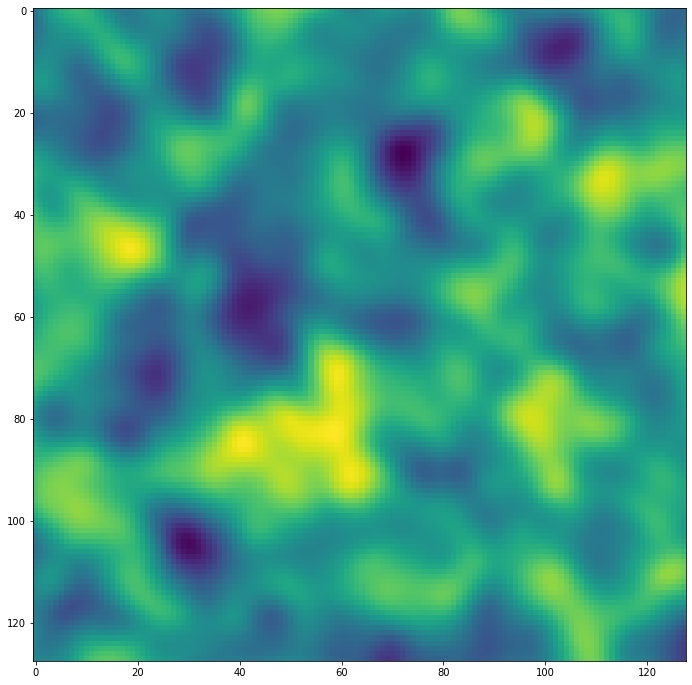

Step 10, Total loss 0.024952


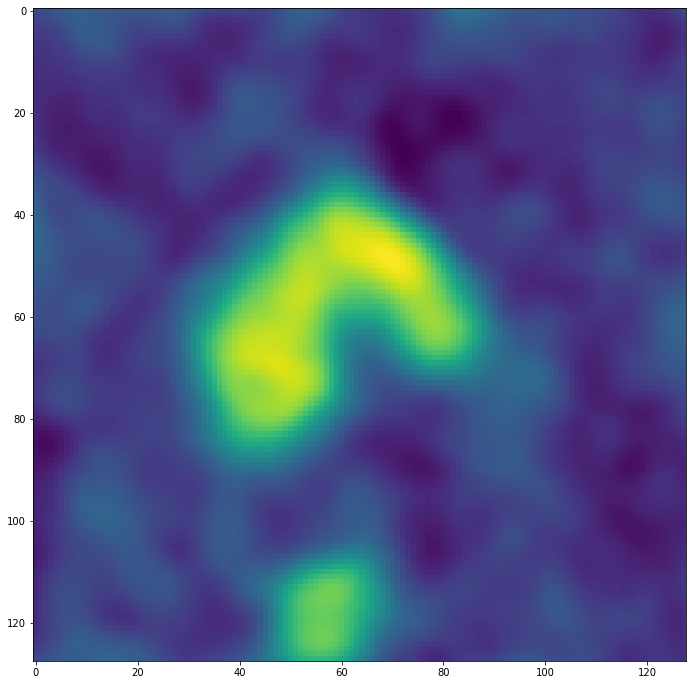

Step 20, Total loss 0.016330


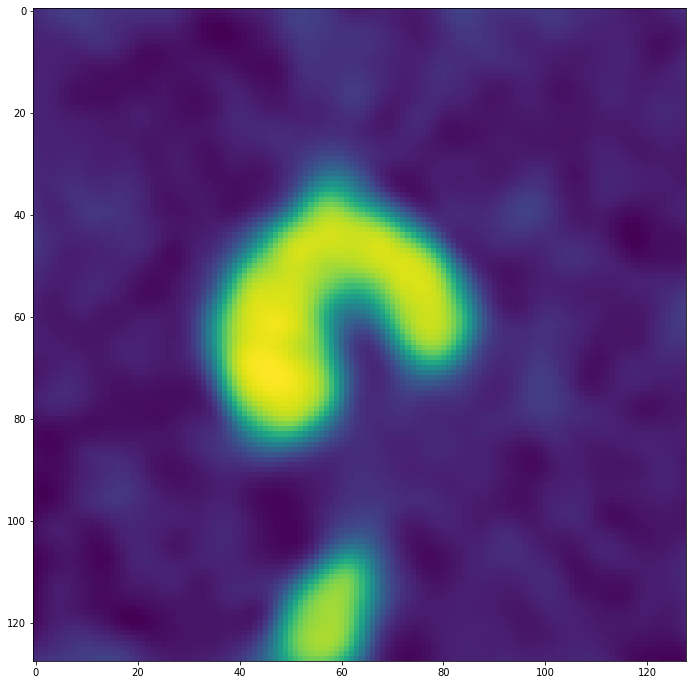

Step 30, Total loss 0.010530


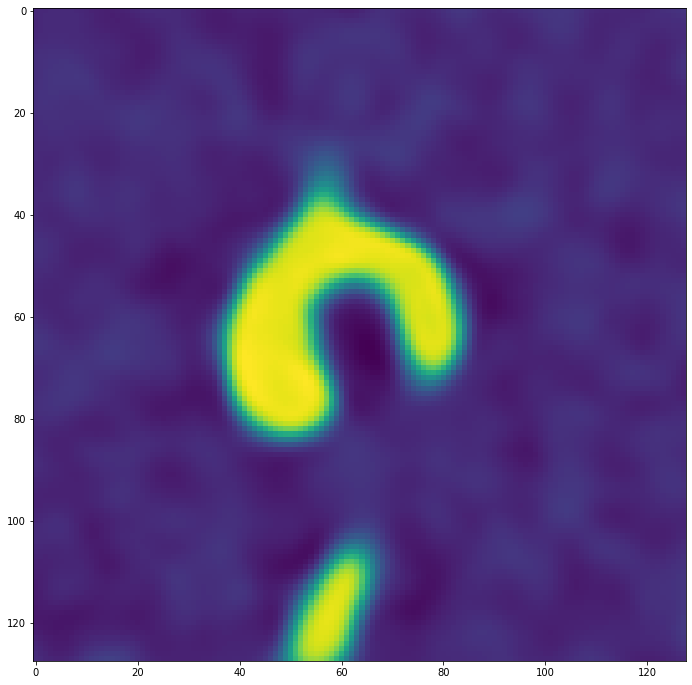

Step 40, Total loss 0.006550


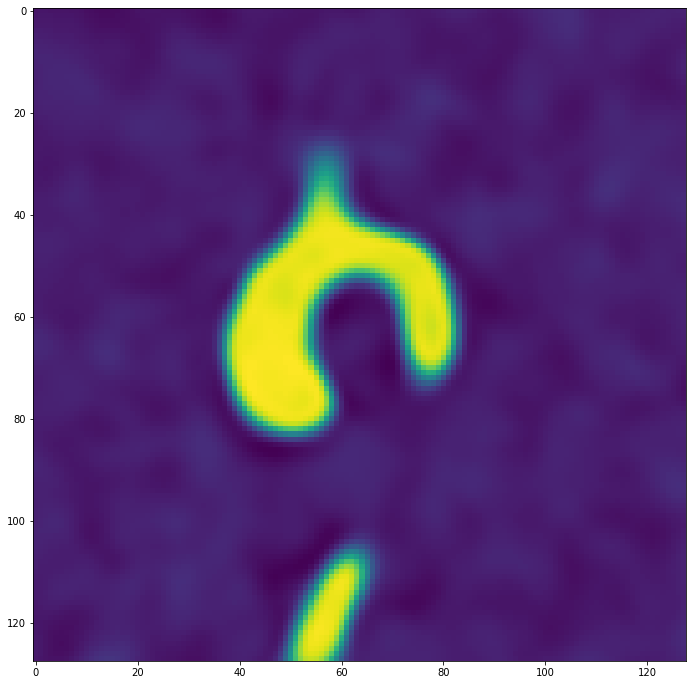

Step 50, Total loss 0.004083


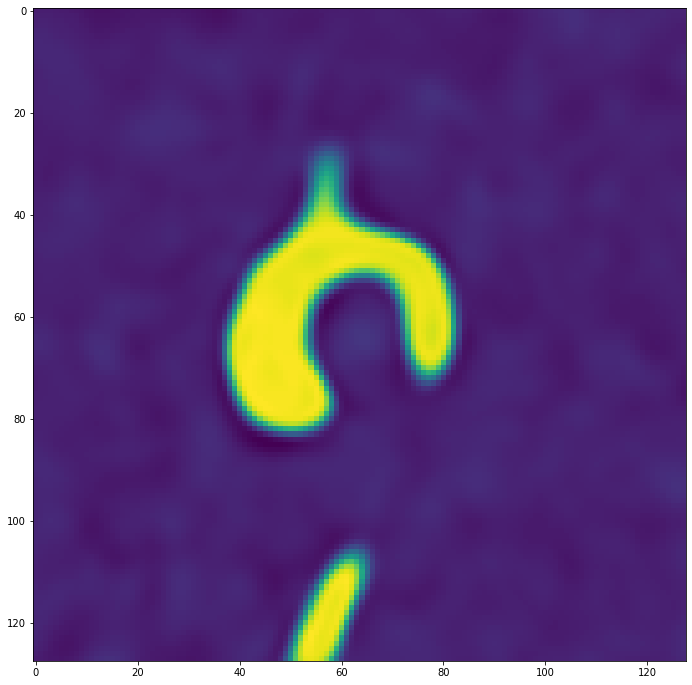

Step 60, Total loss 0.002822


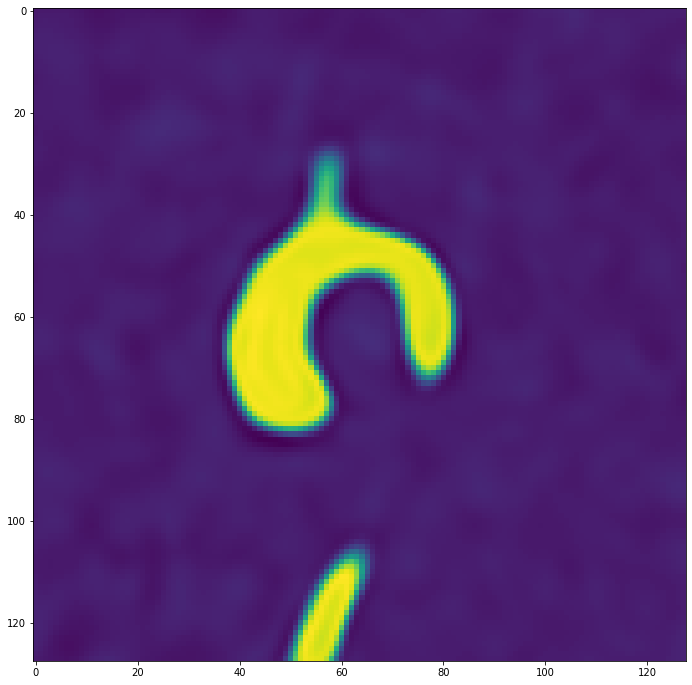

Step 70, Total loss 0.002258


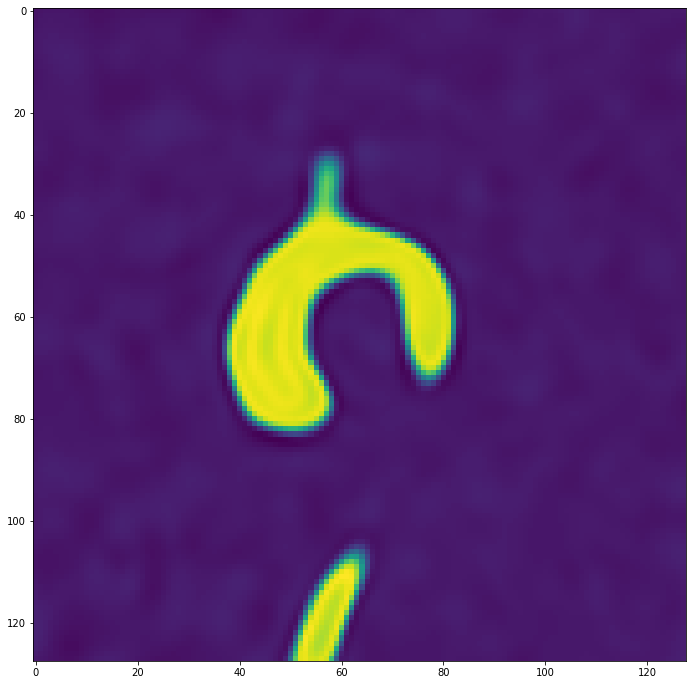

Step 80, Total loss 0.001961


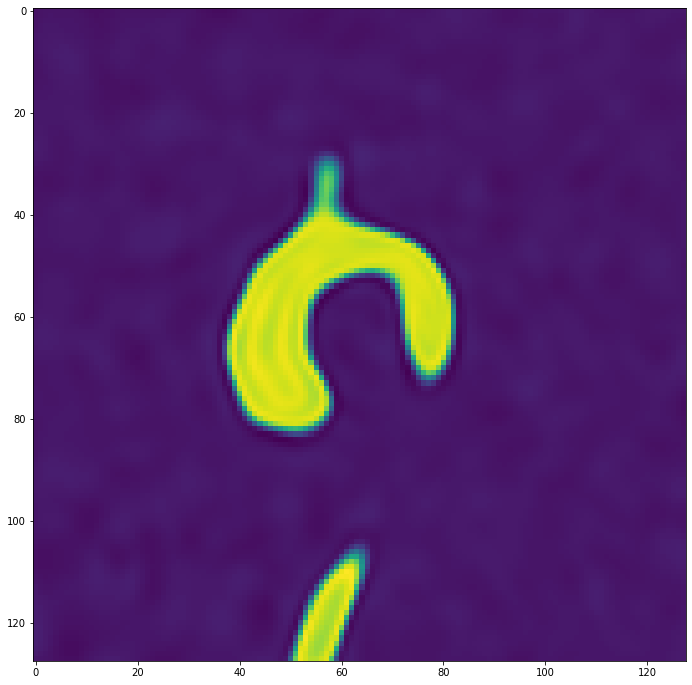

Step 90, Total loss 0.001769


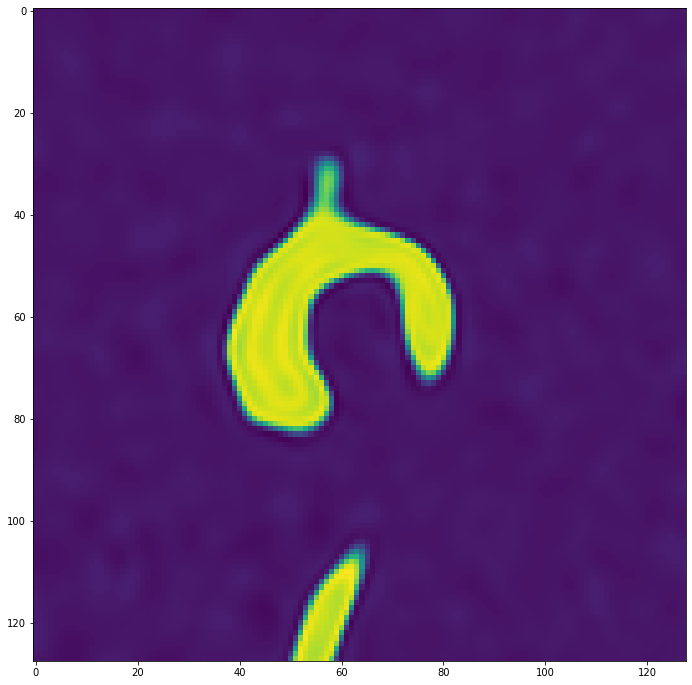

Step 100, Total loss 0.001624


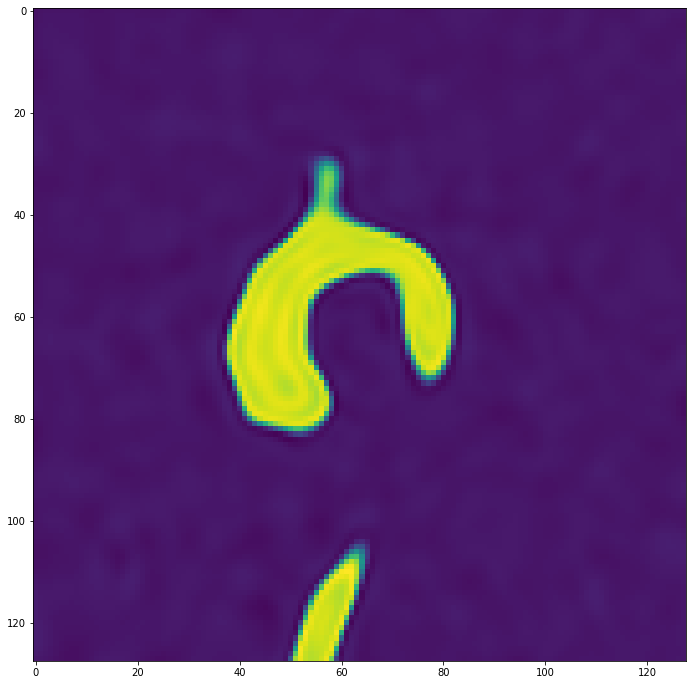

Step 110, Total loss 0.001508


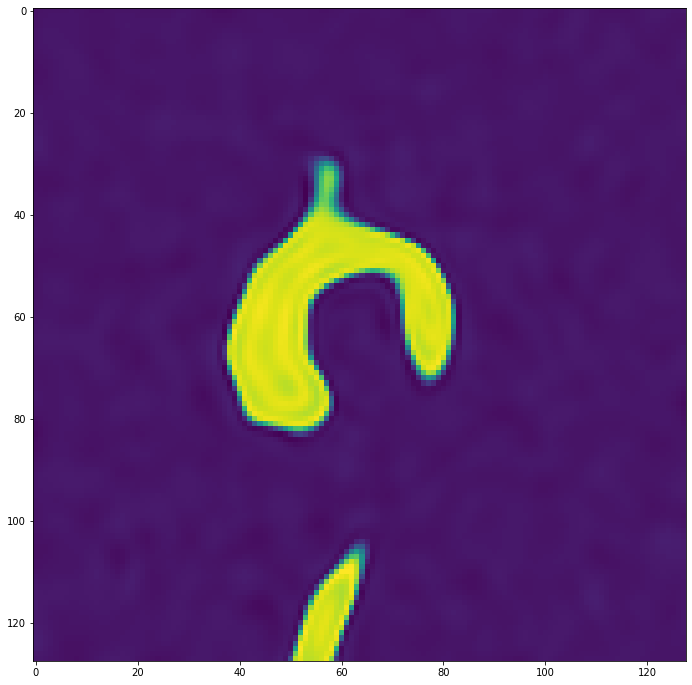

Step 120, Total loss 0.001410


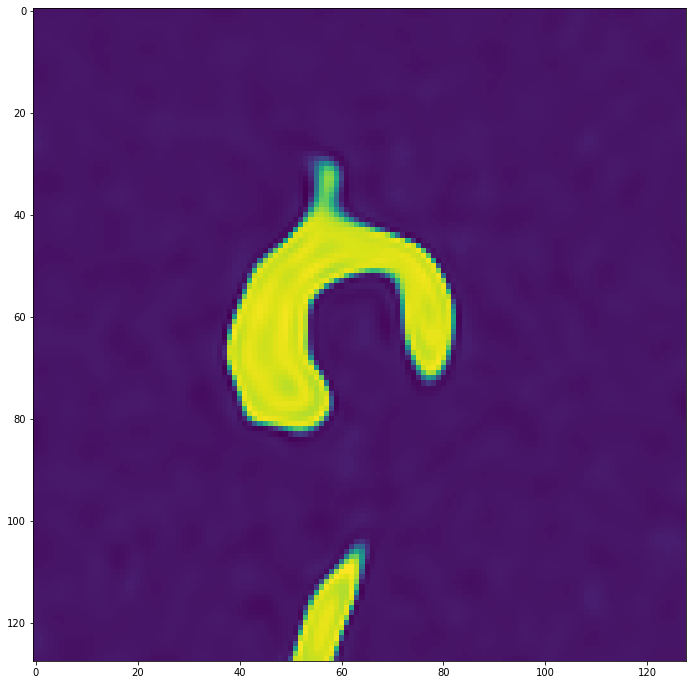

Step 130, Total loss 0.001419


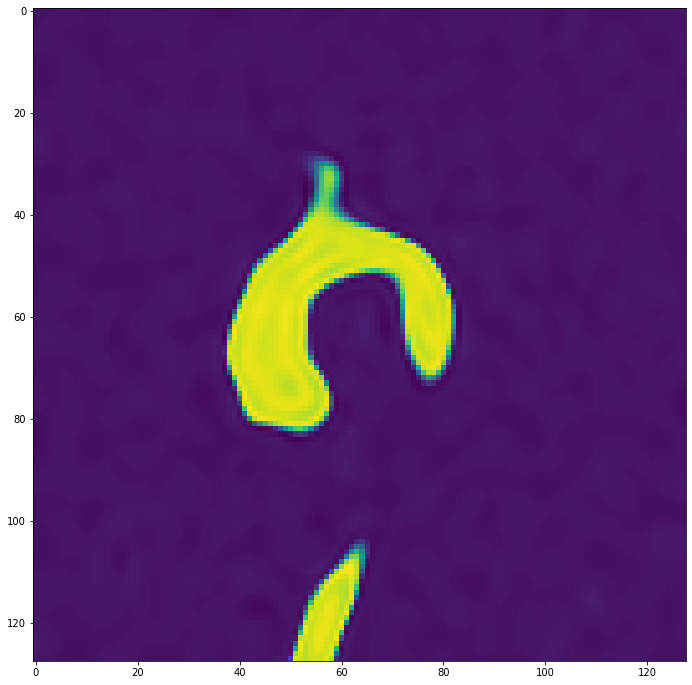

Step 140, Total loss 0.001276


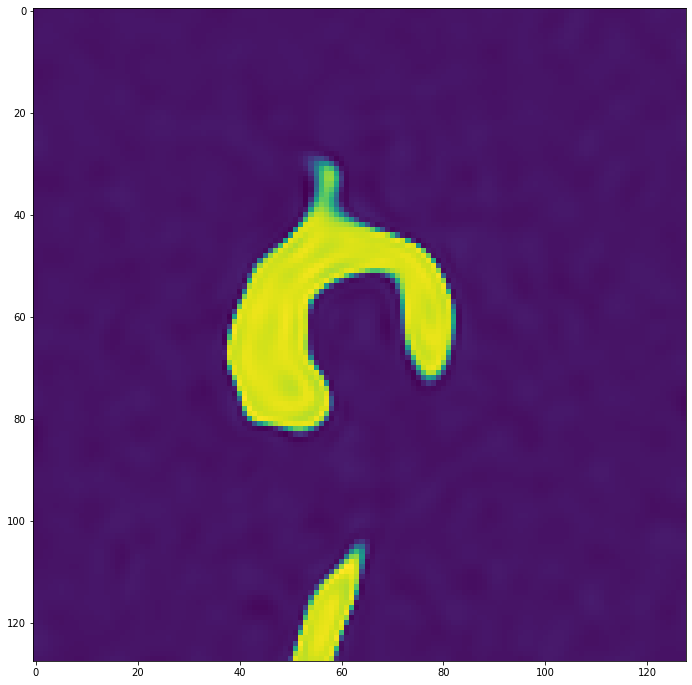

Step 150, Total loss 0.001182


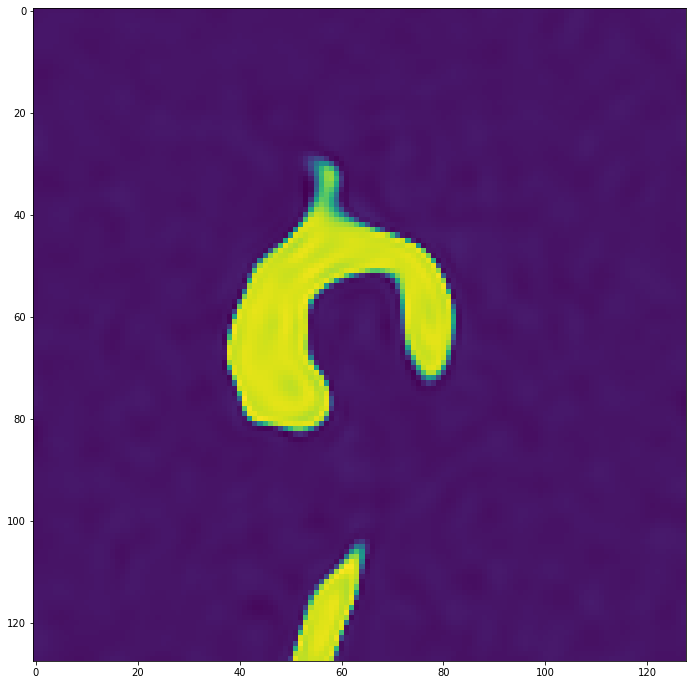

Step 160, Total loss 0.001120


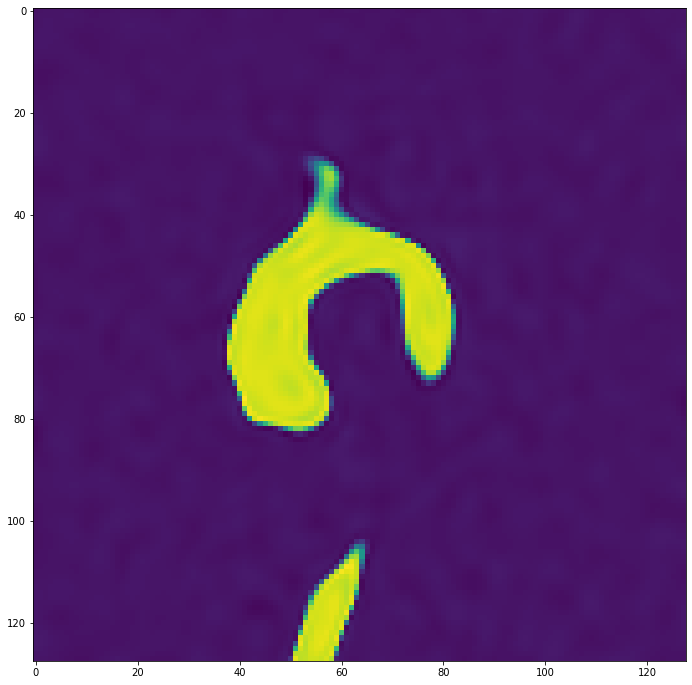

Step 170, Total loss 0.001066


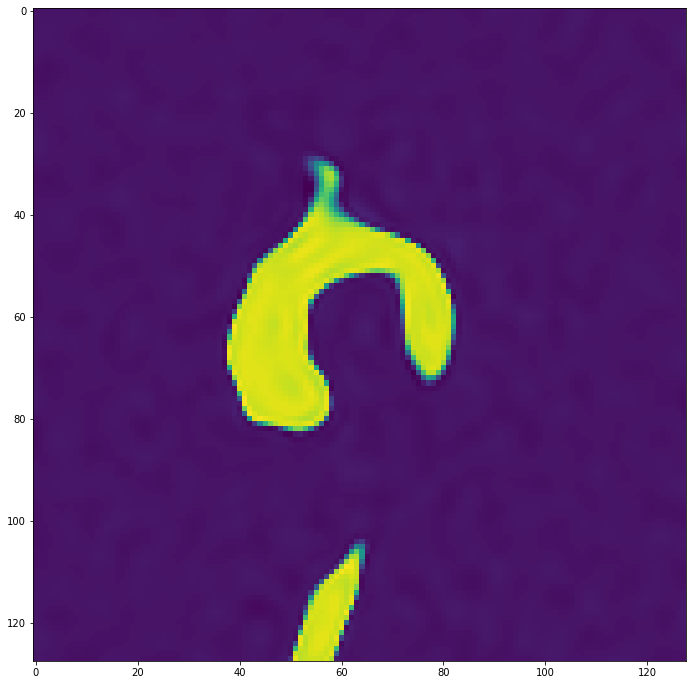

Step 180, Total loss 0.001014


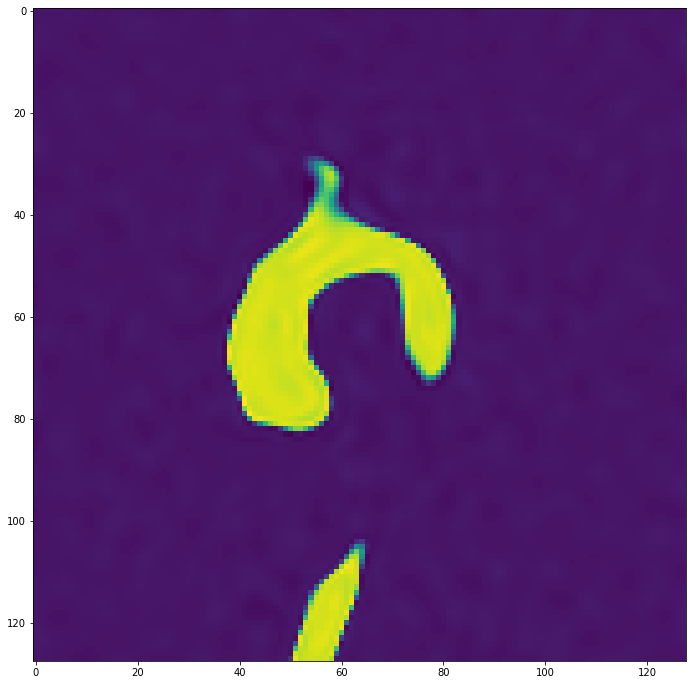

Step 190, Total loss 0.001167


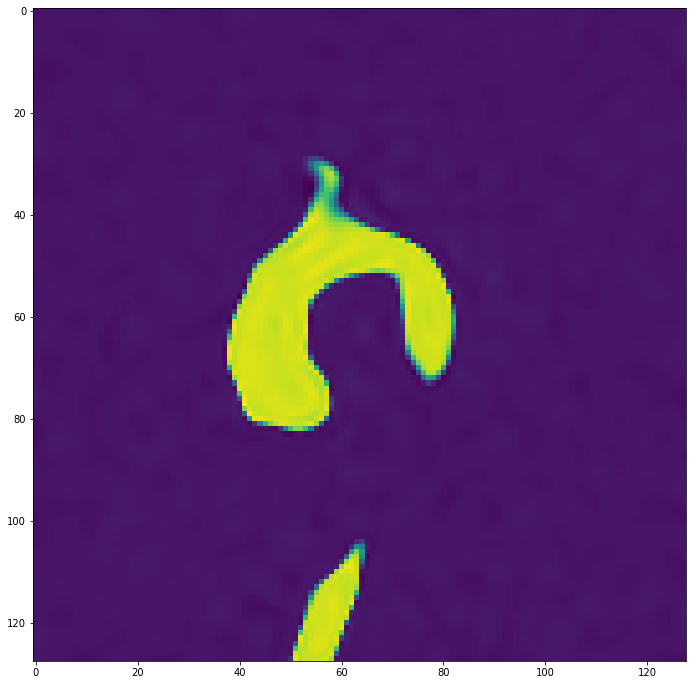

Step 200, Total loss 0.000945


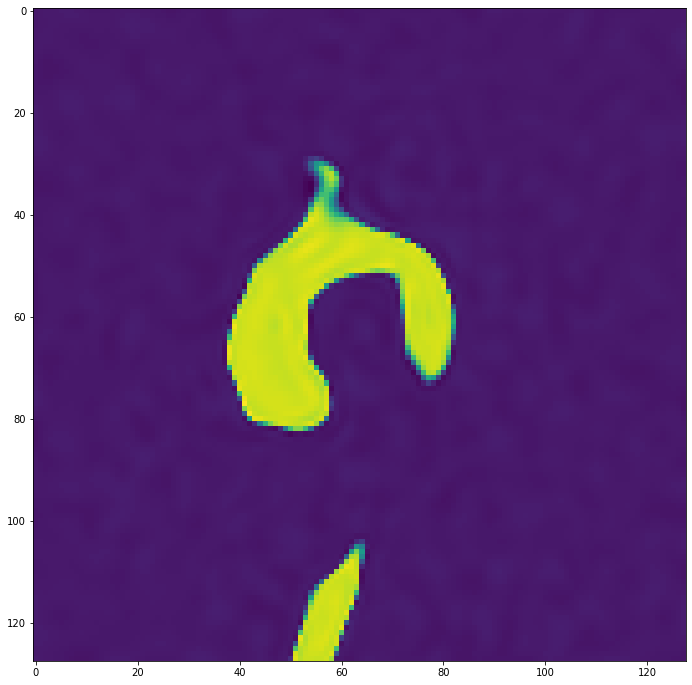

Step 210, Total loss 0.000919


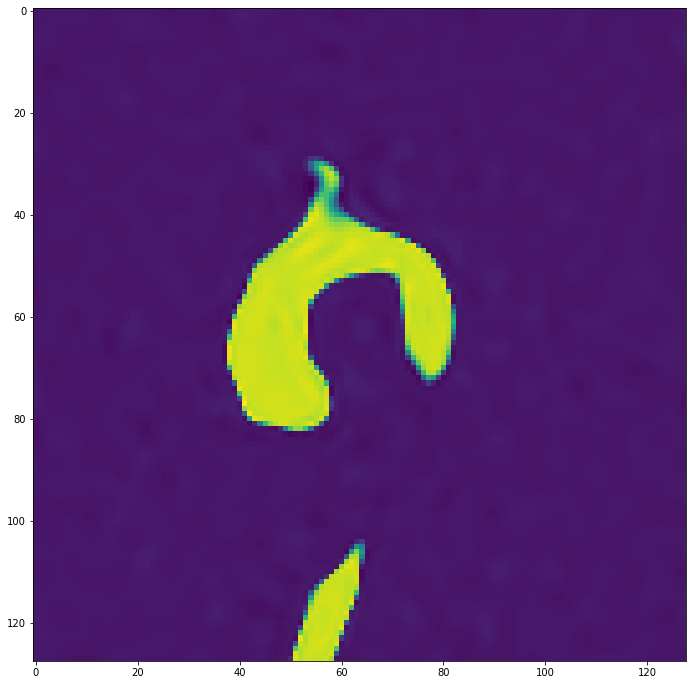

Step 220, Total loss 0.000860


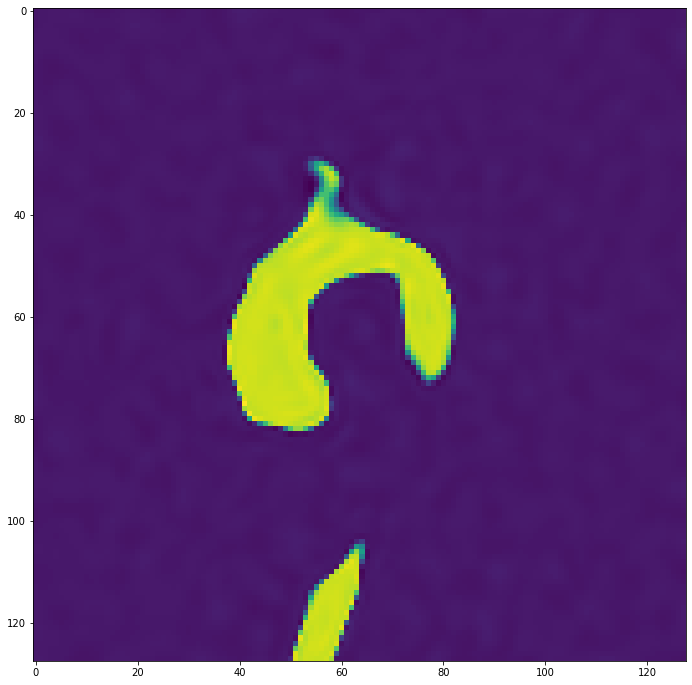

Step 230, Total loss 0.000828


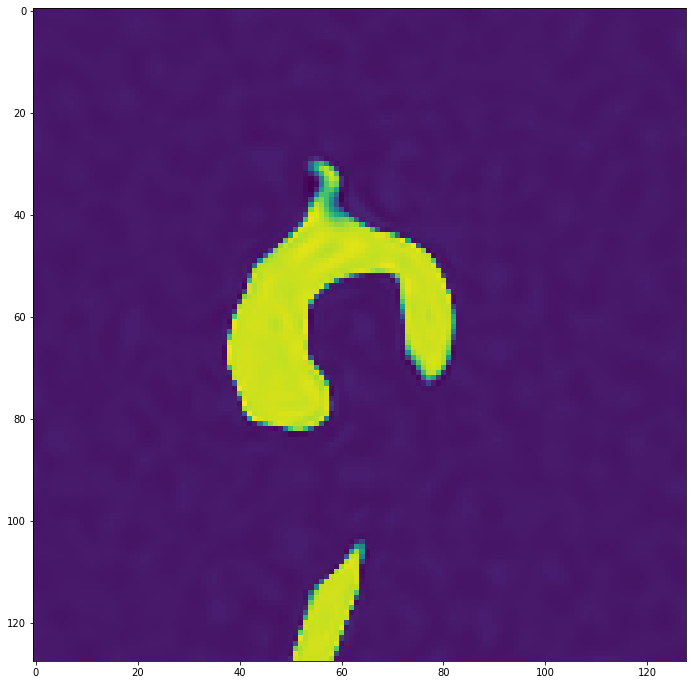

Step 240, Total loss 0.000796


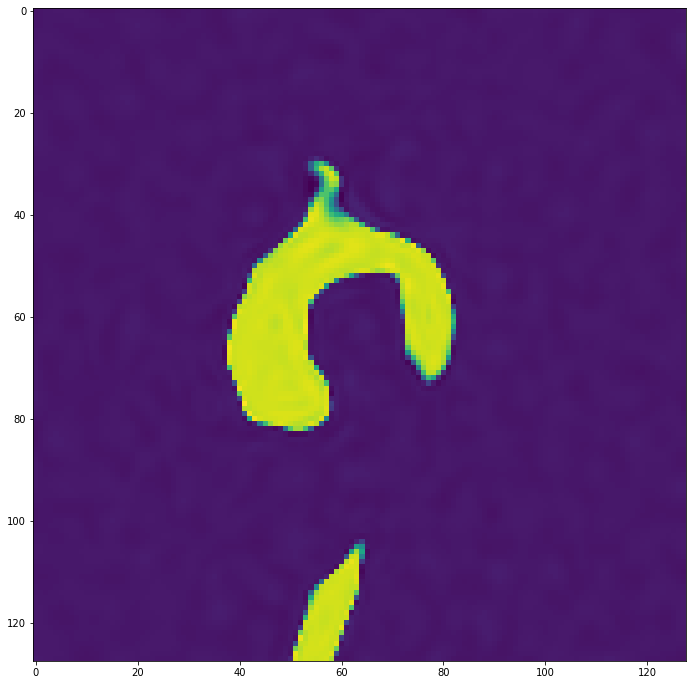

Step 250, Total loss 0.000771


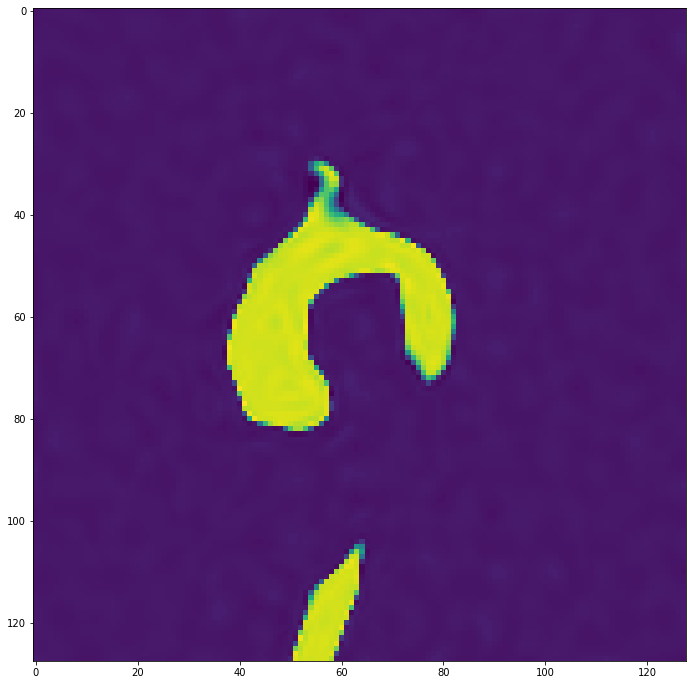

Step 260, Total loss 0.000745


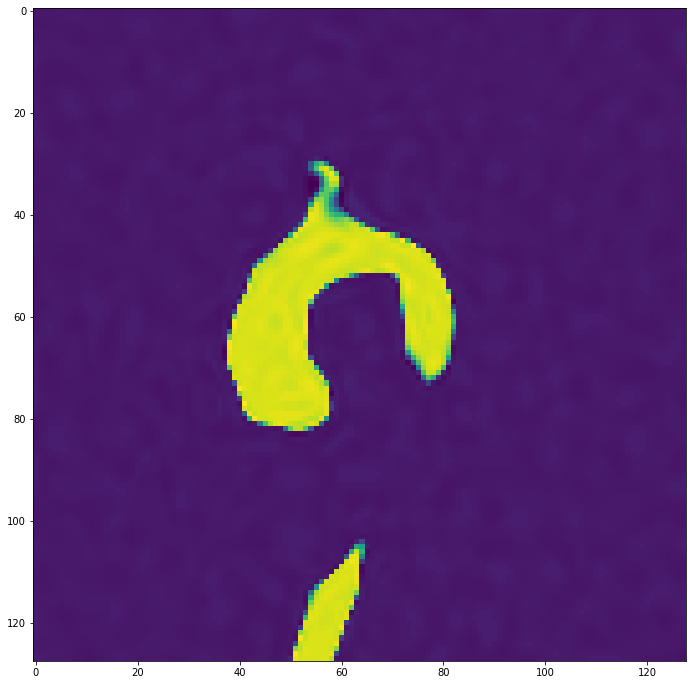

Step 270, Total loss 0.000714


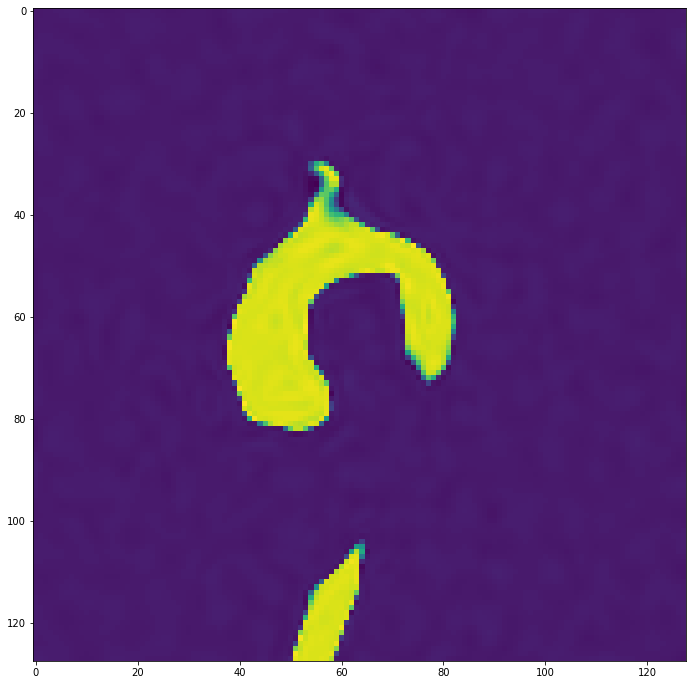

Step 280, Total loss 0.000688


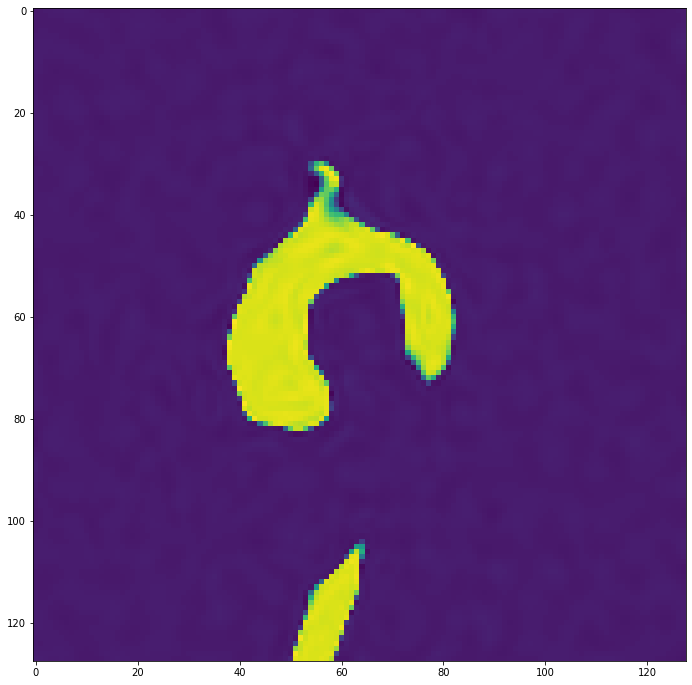

Step 290, Total loss 0.000688


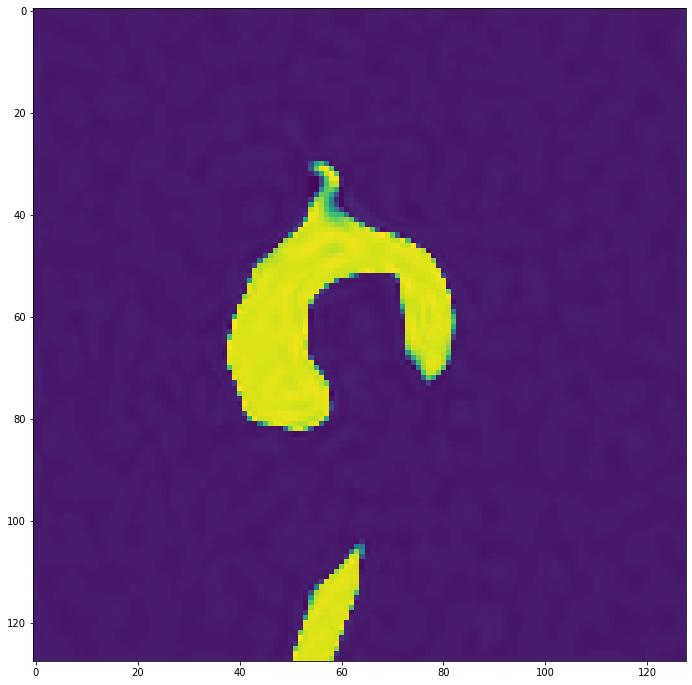

Step 300, Total loss 0.000673


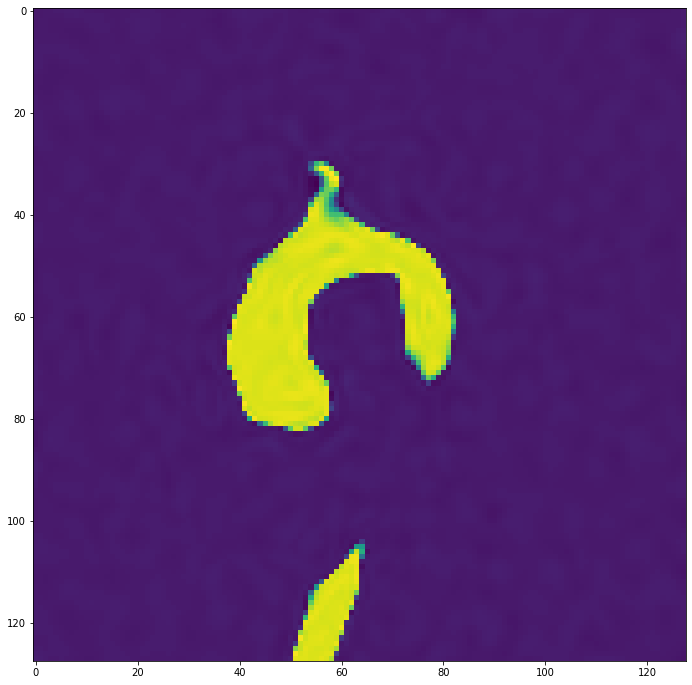

Step 310, Total loss 0.000626


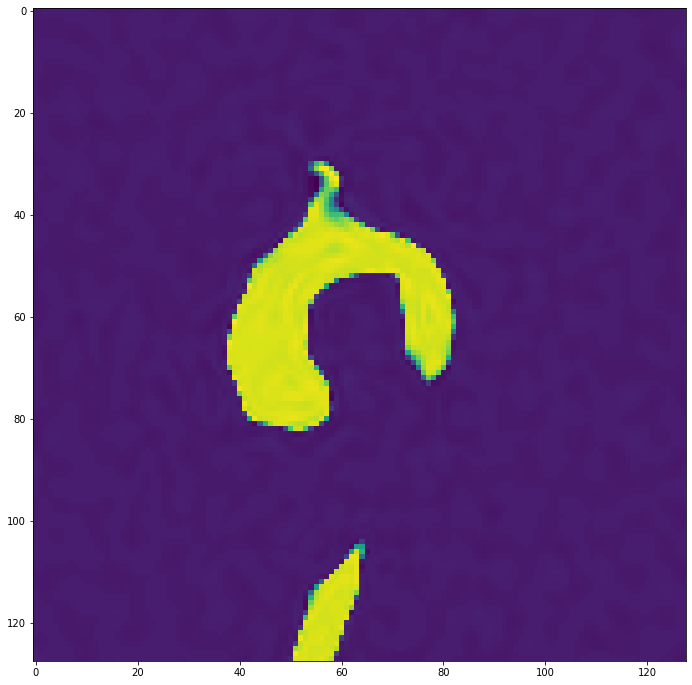

Step 320, Total loss 0.000611


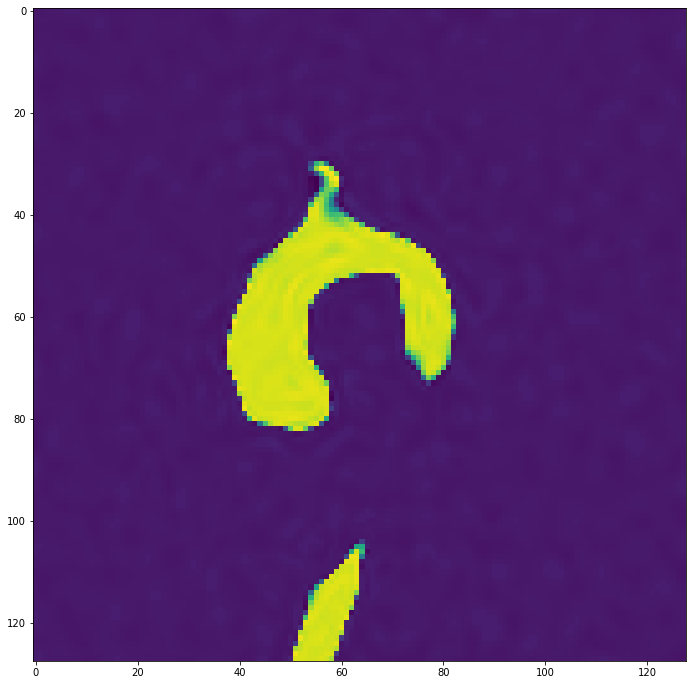

Step 330, Total loss 0.000586


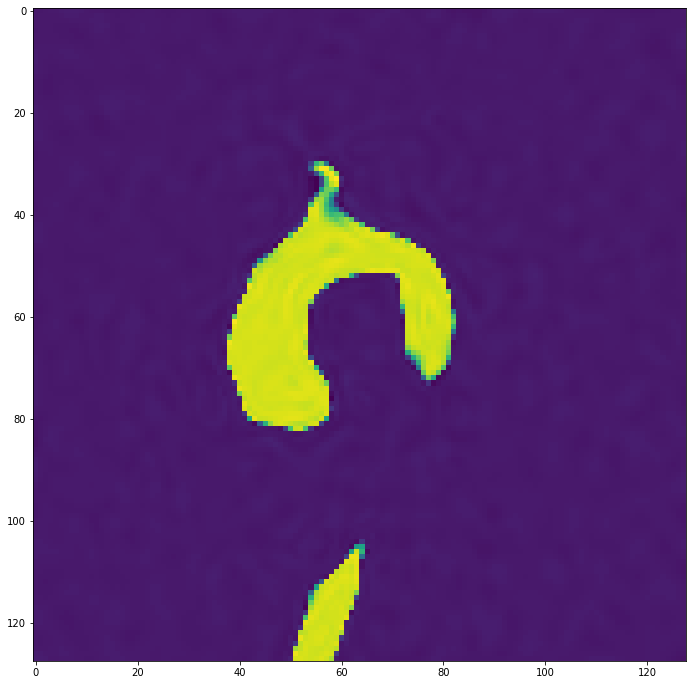

Step 340, Total loss 0.000601


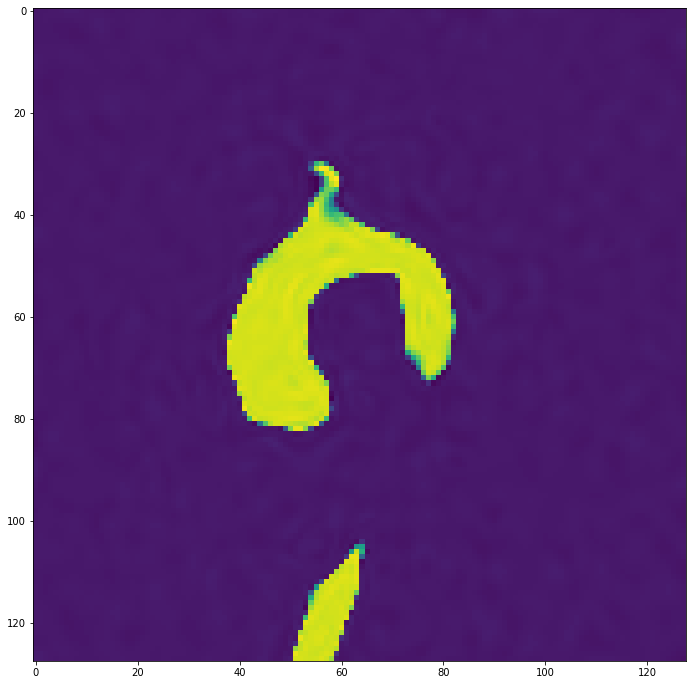

Step 350, Total loss 0.000558


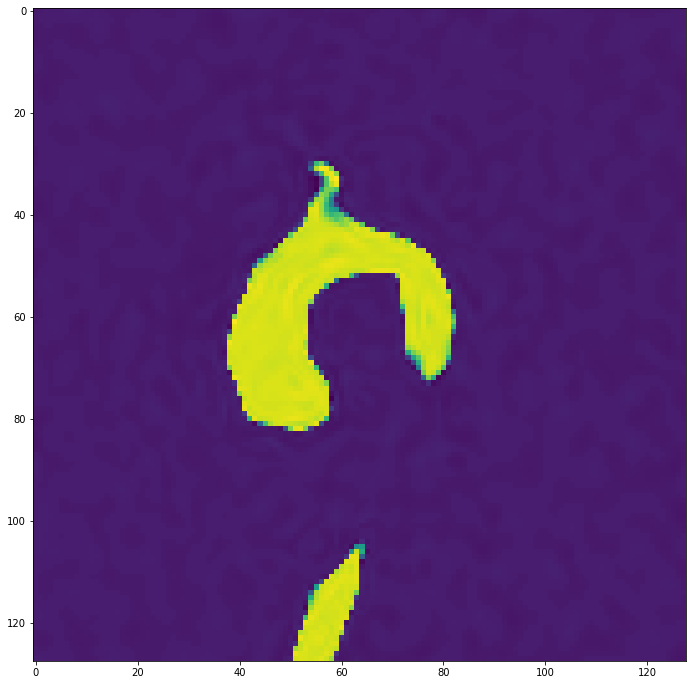

Step 360, Total loss 0.000571


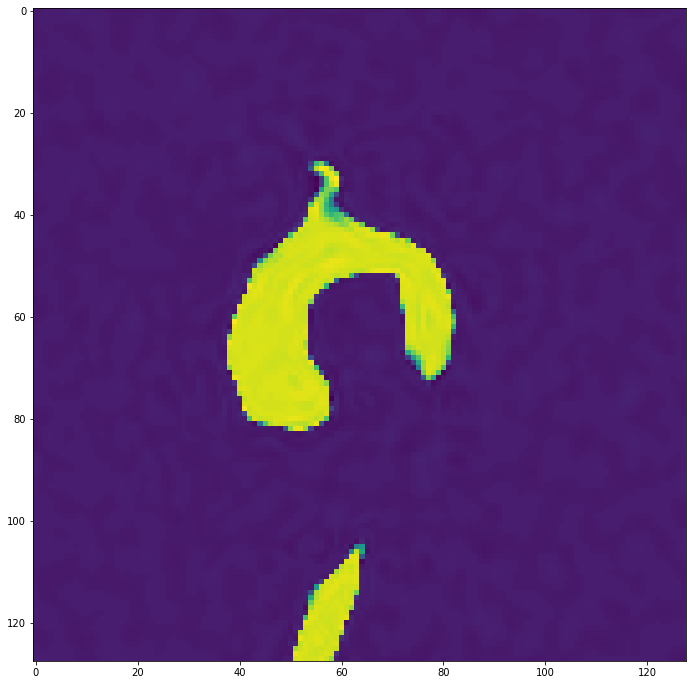

Step 370, Total loss 0.000531


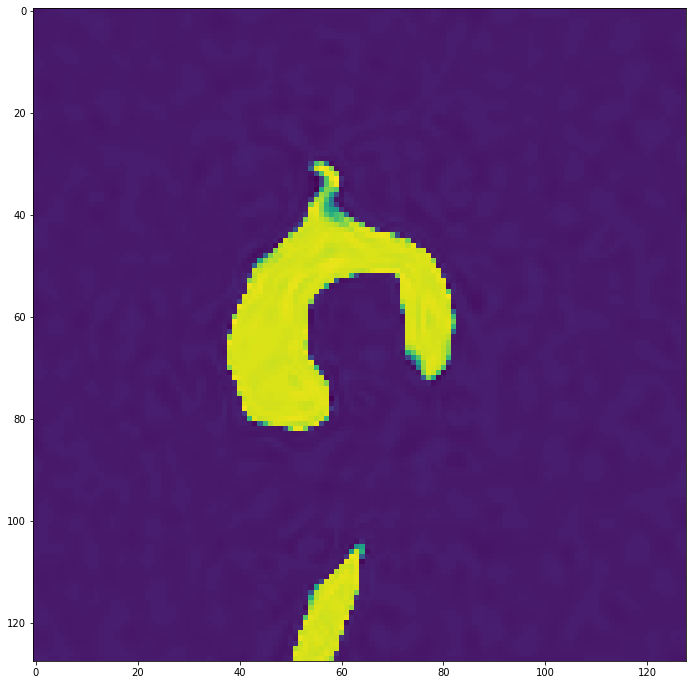

Step 380, Total loss 0.000505


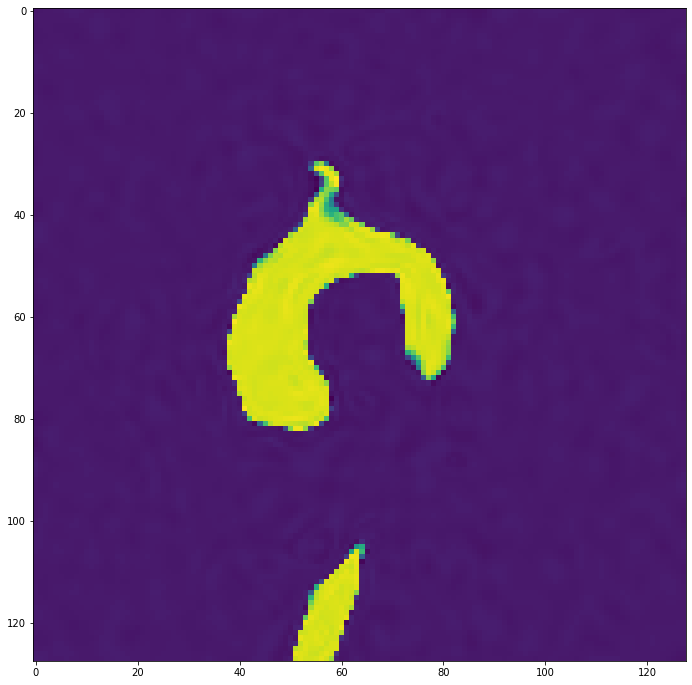

Step 390, Total loss 0.000488


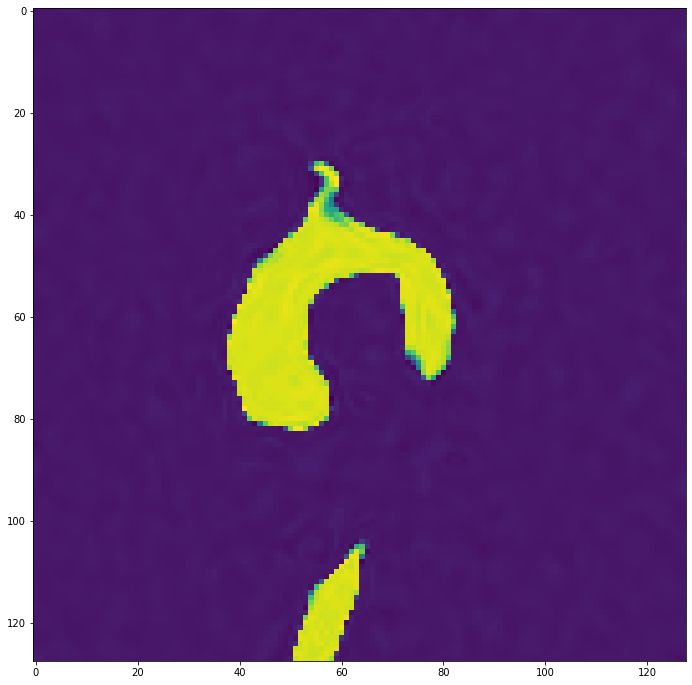

Step 400, Total loss 0.000472


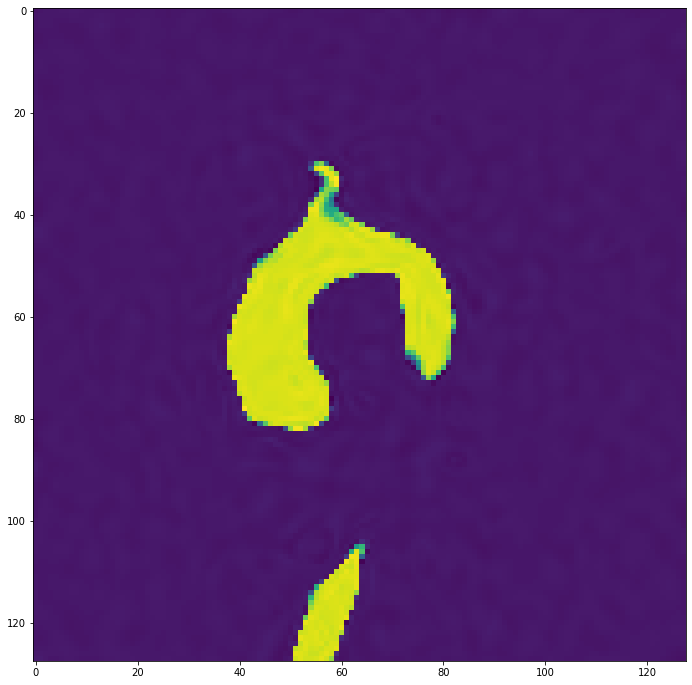

Step 410, Total loss 0.000465


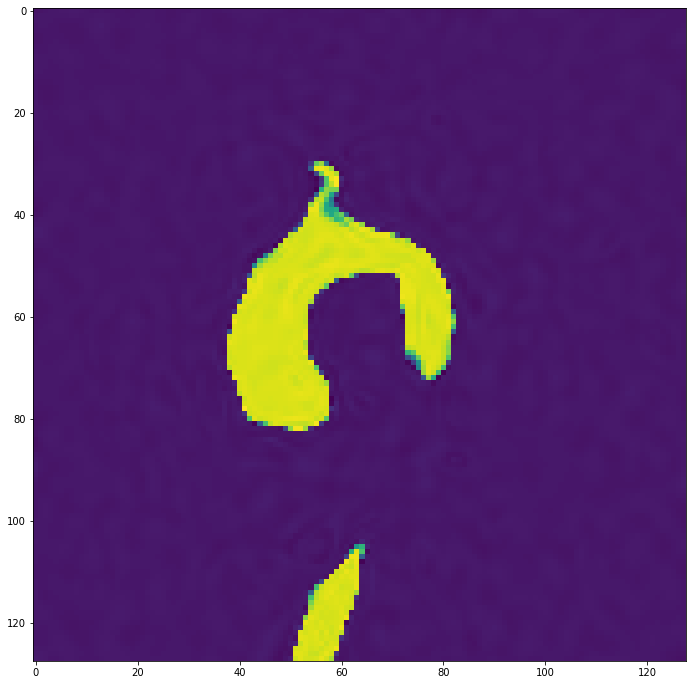

Step 420, Total loss 0.000442


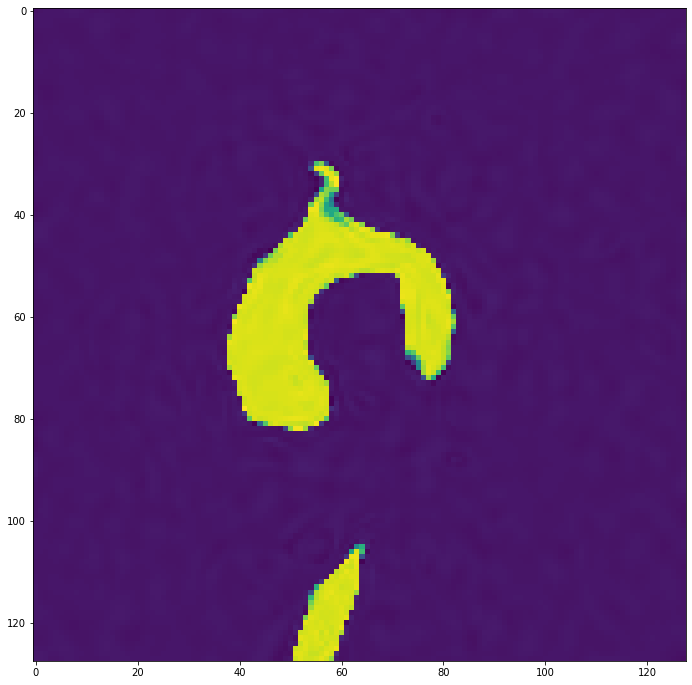

Step 430, Total loss 0.000426


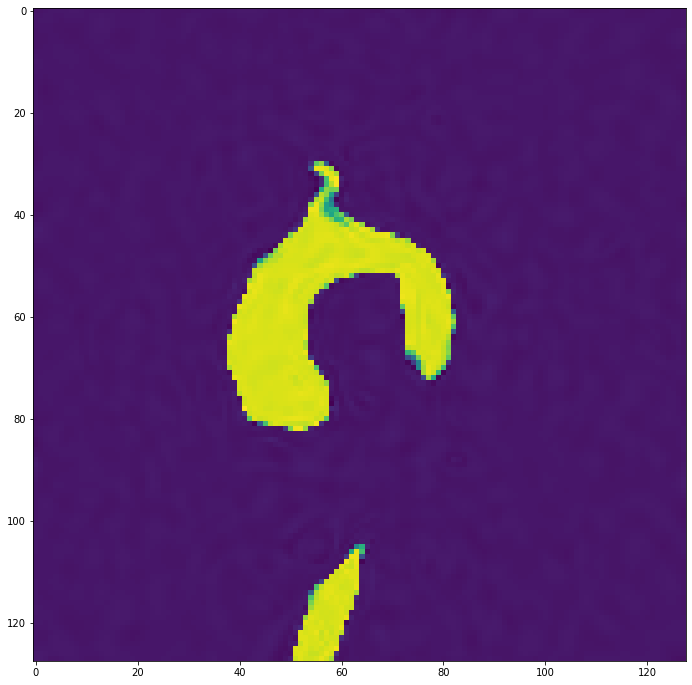

Step 440, Total loss 0.000427


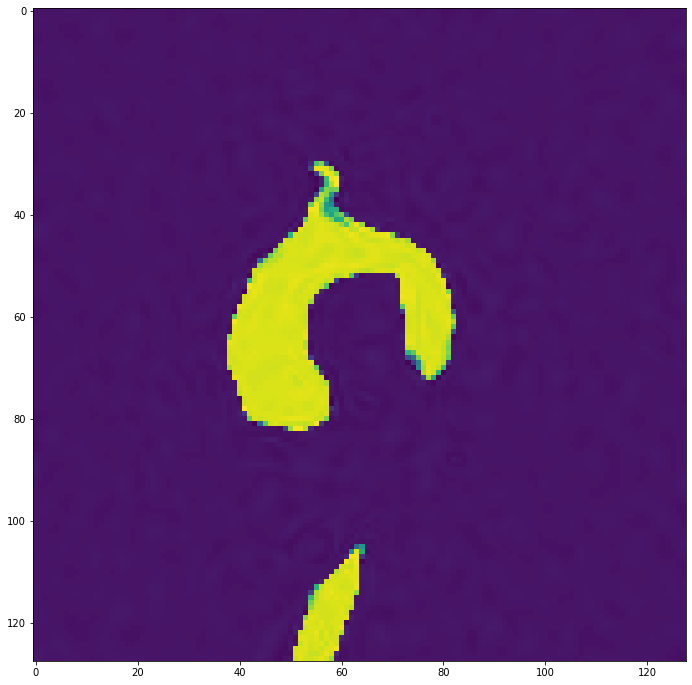

Step 450, Total loss 0.000406


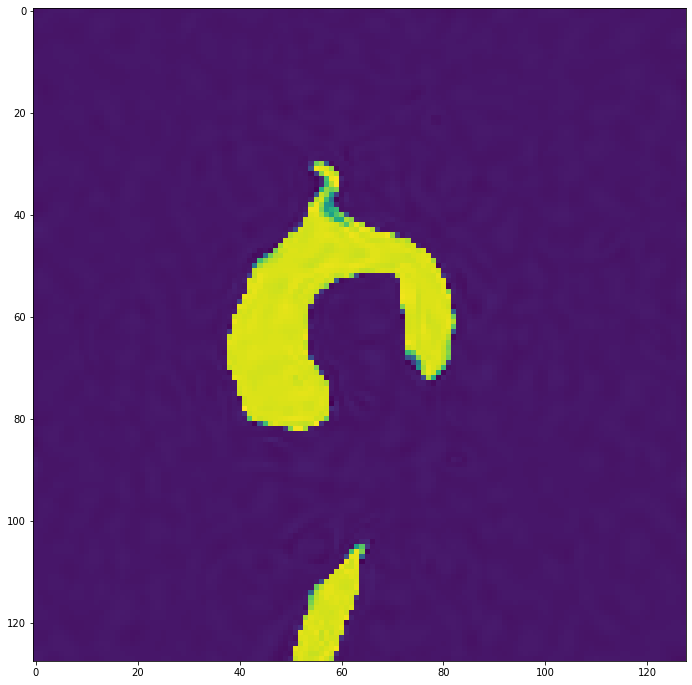

Step 460, Total loss 0.000392


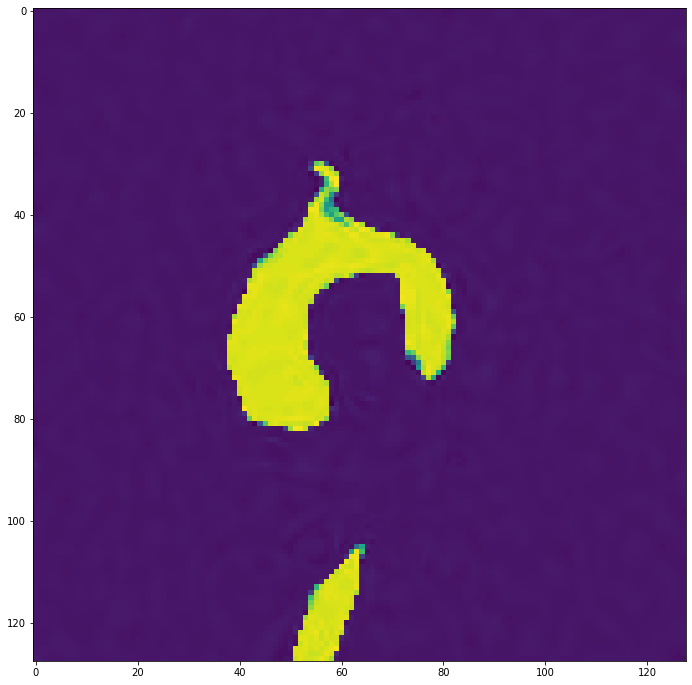

Step 470, Total loss 0.000384


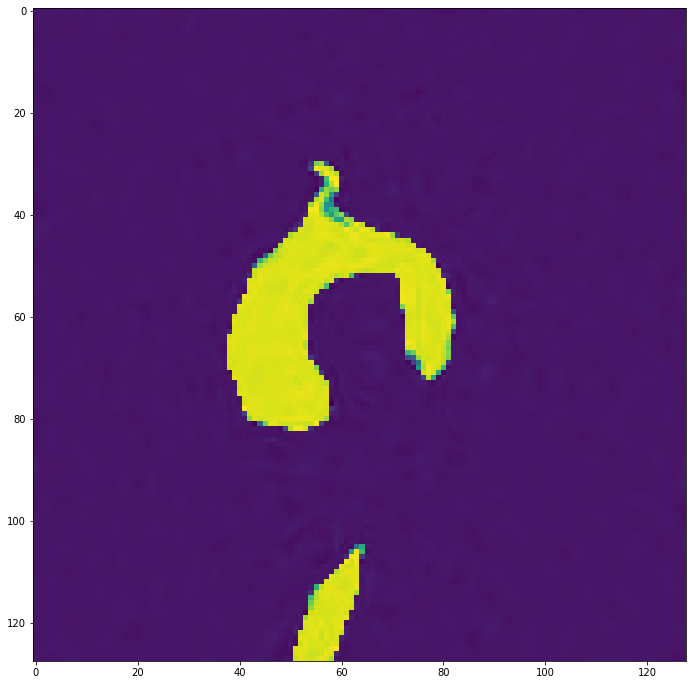

Step 480, Total loss 0.000371


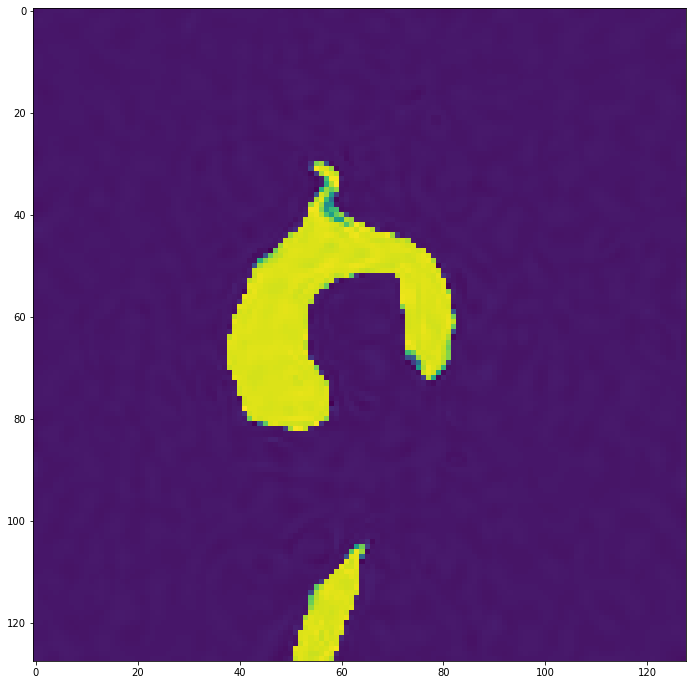

Step 490, Total loss 0.000360


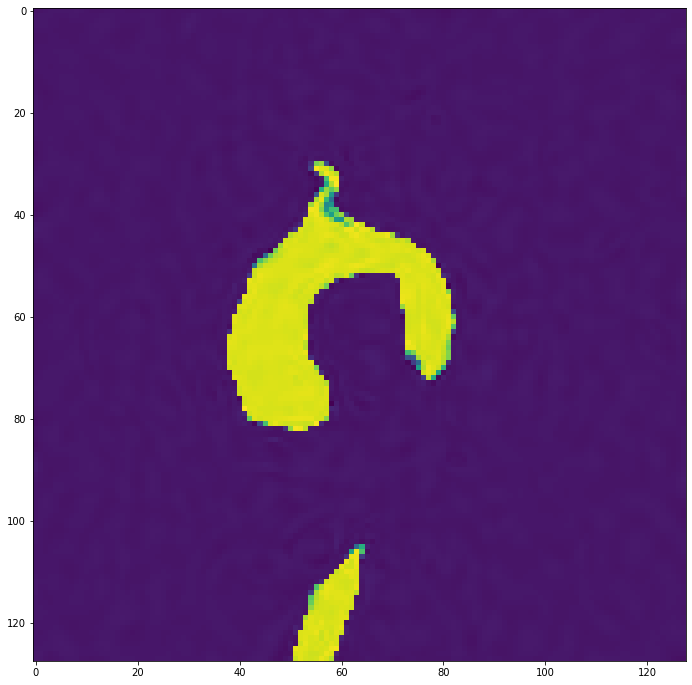

In [21]:
total_steps = 500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

subj, proj, coords, pcmra, mask = next(iter(dataloader))
model_input, ground_truth = coords.cuda(), mask.cuda()

# print(model_input.shape)
mem("Memory")

for step in range(total_steps):
    model_output, coords = img_siren(model_input)  
#     print(model_output.shape)
#     mem("forward pass:")

    loss = ((model_output - ground_truth)**2).mean()
    
#     mem("loss:")

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

        fig, axes = plt.subplots(1,1, figsize=(12,12))
        axes.imshow(model_output.cpu().view(128, 128, 24).detach().numpy()[:, :, 12])

        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()
#     mem("Memory:")



In [22]:
subj, proj, coords, pcmra, mask = next(iter(dataloader))

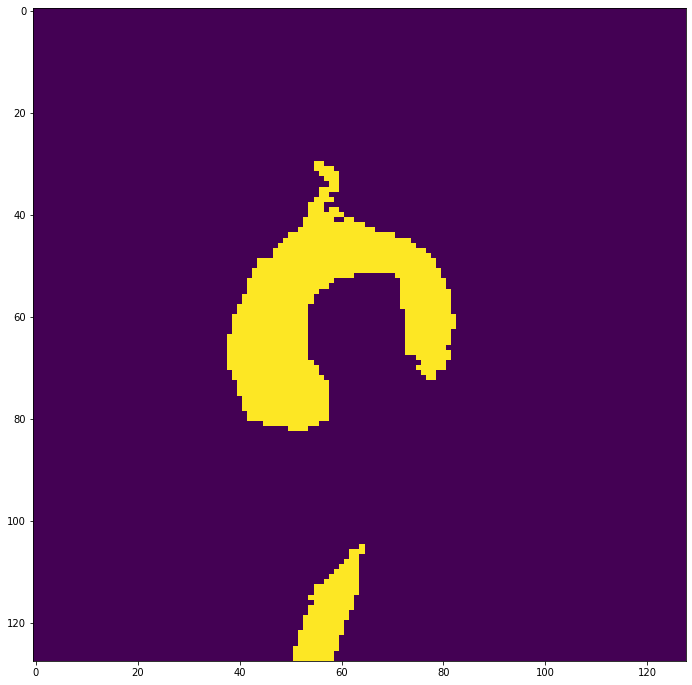

In [23]:
fig, ax = plt.subplots(1,1, figsize=(12,12)) 
ax.imshow(mask.view(128, 128, 24)[:, :, 12])